# 6. Decision Trees

- Versatile models that can perform classification, regression, and multi-output tasks
- Decision trees require very little data preparation; they don't require feature scaling or centring

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# paths
ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")

os.makedirs(
    IMAGES_PATH, exist_ok=True
)  # creates images folder, no error if it already exists


def image_path(file_name):
    return os.path.join(IMAGES_PATH, file_name)


# file names
IRIS_TREE_NAME = "iris_tree.dot"

## Training and Visualising a Decision Tree

In [31]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# import iris sample data
iris = load_iris()

X = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
y = iris["target"]

# shuffle since data is ordered by class
X, y = shuffle(X, y)

# restrict to 2 features
X_petal = X[["petal length (cm)", "petal width (cm)"]]

tree_clf = DecisionTreeClassifier(max_depth=2)  # max_depth determines how many branches
tree_clf.fit(X_petal, y);

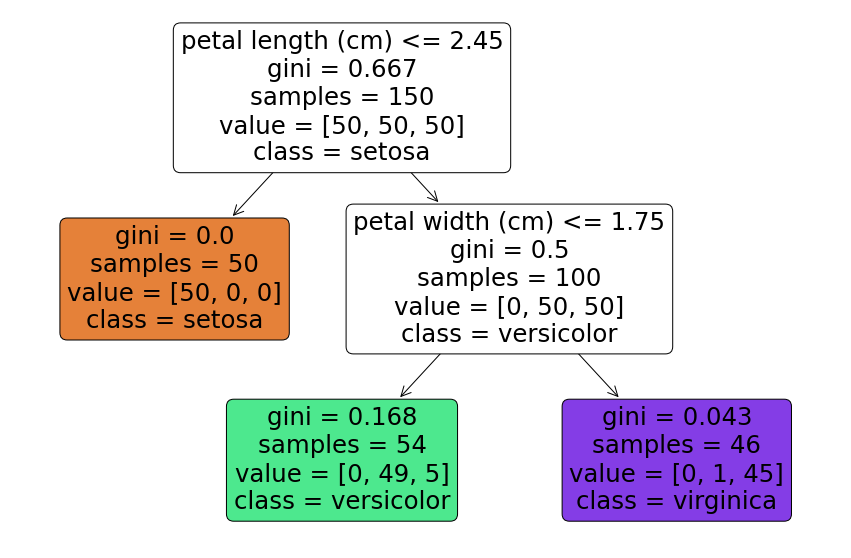

In [32]:
# visualise the tree directly
from sklearn.tree import export_graphviz, plot_tree

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(
    tree_clf,
    feature_names=X_petal.columns,
    class_names=iris["target_names"],
    rounded=True,
    filled=True,
);

In [5]:
# or using graphviz
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    tree_clf, out_file=image_path(IRIS_TREE_NAME)
)  # saved to DOT graph description format
# graphviz.Source.from_file(image_path(IRIS_TREE_NAME))

I can't get the cell above to work - homebrew fails when trying to install graphviz

## Making Predictions

- Start at the *root node* (depth 0) and look at the first condition - go *left* if the statement is *true*
- The left child node at depth 1 is a *leaf node* - it doesn't have any child nodes and predicts class setosa
- The `samples` attribute counts how many training instances went through that node
- The `gini` attribute gives the *Gini impurity* $G$: if $p_k$ is the proportion of instances of class $k$ that go through that node then

\begin{equation}
    G = 1 - \sum_{k=1}^n p_k^2
\end{equation}

- A node is *Gini pure* ($G=0$) if all instances are of the same class
- Each node in a decision tree partitions a feature in two, so the decision boundaries are made up of vertical and horizontal lines

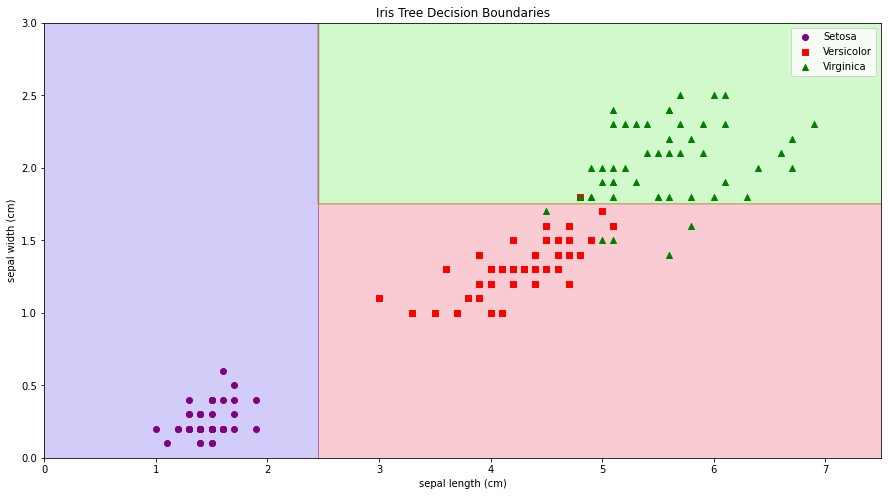

In [33]:
# decision boundaries
def plot_class_predictions(clf, xlim, ylim):
    # generate values along each axis
    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)
    
    # all combinations of (x0, x1) for plot
    x0, x1 = np.meshgrid(x0s, x1s)

    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


def plot_data(X, y):
    plt.scatter(
        X[:, 0][y == 0],
        X[:, 1][y == 0],
        marker="o",
        color="purple",
        label="Setosa"
    )
    plt.scatter(
        X[:, 0][y == 1],
        X[:, 1][y == 1],
        marker="s",
        color="red",
        label="Versicolor"
    )
    plt.scatter(
        X[:, 0][y == 2],
        X[:, 1][y == 2],
        marker="^",
        color="green",
        label="Virginica"
    )


xlim = np.array([0, 7.5])
ylim = np.array([0, 3])

fig, ax = plt.subplots(figsize=(15, 8))

plot_class_predictions(tree_clf, xlim, ylim)
plot_data(X_petal.values, y)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])

ax.set_title("Iris Tree Decision Boundaries")

ax.legend();